In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)

In [4]:
data = pd.read_csv(r'ml_data_cleaned_rfm.csv')

In [5]:
data.drop(columns=['OrderID', 'CustomerFirstName', 
                   'CustomerLastName', 'TransactionDate', 
                   'CustomerDateOfBirth', 'CustomerSignupDate',
                   'RFM_Score', 'Frequency', 'Monetary'], inplace=True)

### Problem Statement: Train a Model to Predict Customer Lifetime Value 
Target Variable: Customer Segment

### Feature Encoding

- Target Customer segment is encoded using Label Encoder because it is an ordinal categorical variables and label maintains that orderliness.
  
- PaymentMethod, SalesChannel and CustomerGender are Non ordinal and have small cardinality (number of unique values), so one hot encoding or dummy encoding is the most appropriate.
  
- For high cardinal column, frequency mapping is been used. 


In [6]:
one_hot_cols = ['PaymentMethod', 'SalesChannel', 'CustomerGender']
encoded_data = pd.get_dummies(data, columns=one_hot_cols, drop_first=True)

label_enc = LabelEncoder()
encoded_data['CustomerSegment'] = label_enc.fit_transform(encoded_data['CustomerSegment'])

high_cardinality_cols = ['ProductName', 'Category', 'CustomerCity', 'CustomerCountry']

for col in high_cardinality_cols:
    freq_map = encoded_data[col].value_counts(normalize=True)
    encoded_data[col] = encoded_data[col].map(freq_map)

encoded_data.head()


,Quantity,ProductName,Category,UnitPrice,CustomerCountry,CustomerCity,IsCurrent,CustomerAge,Revenue,Recency,CustomerSegment,PaymentMethod_Card,PaymentMethod_Cash,PaymentMethod_Crypto,PaymentMethod_Other,PaymentMethod_PayPal,SalesChannel_Website,CustomerGender_Male
0,7,0.102207,0.280141,1014.02,0.100079,0.019586,True,59,7098.14,0.047334,2,True,False,False,False,False,True,True
1,72,0.098746,0.269335,749.90,0.099629,0.019701,True,57,53992.80,0.001797,0,False,True,False,False,False,False,False
2,95,0.089478,0.089478,471.11,0.099930,0.019902,True,53,44755.45,0.003595,2,False,False,False,False,True,False,False
3,15,0.102207,0.280141,1415.66,0.100079,0.019691,True,42,21234.90,0.019173,2,False,False,False,False,True,True,False
4,7,0.087813,0.269335,1362.50,0.100390,0.019749,True,30,9537.50,0.053325,2,False,False,False,False,False,True,True


### Split into training and testing set

In [7]:
X = encoded_data.drop(columns=['CustomerSegment'])# Drop target column
y = encoded_data['CustomerSegment'] # Target variable

# Split into train (80%) and test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print dataset shapes
print(f"Training Set: X_train = {X_train.shape}, y_train = {y_train.shape}")
print(f"Testing Set: X_test = {X_test.shape}, y_test = {y_test.shape}")


Training Set: X_train = (2790252, 17), y_train = (2790252,)
Testing Set: X_test = (697563, 17), y_test = (697563,)


### Training a Logistics Regression Model

In [6]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize and train Logistic Regression
model = LogisticRegression(multi_class='ovr', solver='liblinear')
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

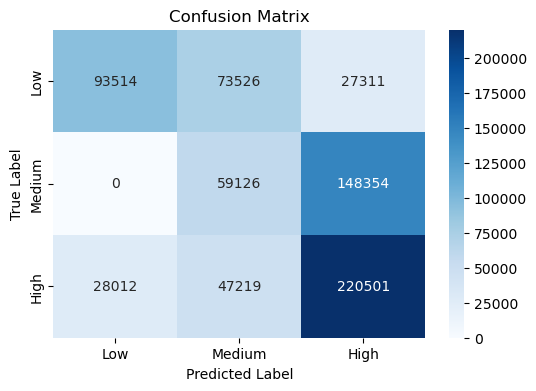

              precision    recall  f1-score   support

         Low       0.77      0.48      0.59    194351
      Medium       0.33      0.28      0.31    207480
        High       0.56      0.75      0.64    295732

    accuracy                           0.53    697563
   macro avg       0.55      0.50      0.51    697563
weighted avg       0.55      0.53      0.53    697563



In [7]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Low', 'Medium', 'High'], yticklabels=['Low', 'Medium', 'High'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Print classification report
print(classification_report(y_test, y_pred, target_names=['Low', 'Medium', 'High']))

# RandomForest

In [27]:
# Train a model
model = RandomForestClassifier(n_estimators=10, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


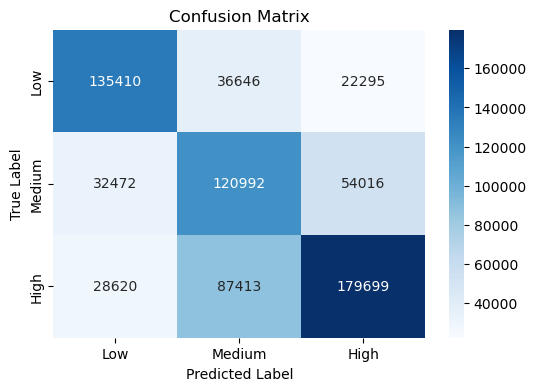

              precision    recall  f1-score   support

         Low       0.69      0.70      0.69    194351
      Medium       0.49      0.58      0.53    207480
        High       0.70      0.61      0.65    295732

    accuracy                           0.63    697563
   macro avg       0.63      0.63      0.63    697563
weighted avg       0.64      0.63      0.63    697563



In [29]:
cm = confusion_matrix(y_test, y_pred)
class_labels = ['Low', 'Medium', 'High']

# Plot confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_test, y_pred, target_names=class_labels))

## XGBOOST

In [14]:
xgb_model = XGBClassifier(n_estimators = 100, learning_rate = 0.1, random_state = 42)

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

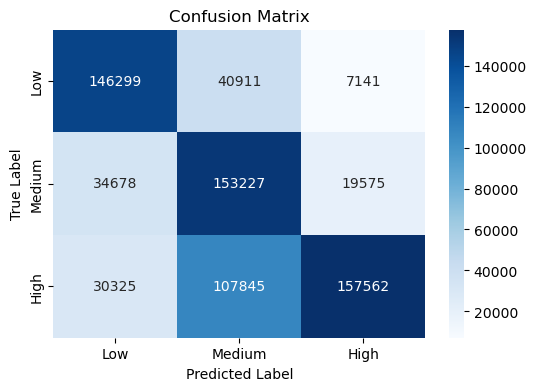

              precision    recall  f1-score   support

         Low       0.69      0.75      0.72    194351
      Medium       0.51      0.74      0.60    207480
        High       0.86      0.53      0.66    295732

    accuracy                           0.66    697563
   macro avg       0.68      0.67      0.66    697563
weighted avg       0.71      0.66      0.66    697563



In [15]:
cm = confusion_matrix(y_test, y_pred)
class_labels = ['Low', 'Medium', 'High']

# Plot confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(y_test, y_pred, target_names=class_labels))